In [ ]:
import torch
import random
import Model
import librosa
import librosa.display
import numpy as np
import hyperparams as hp
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt      

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torch.utils.data.dataset import Subset
from tqdm import tqdm
from PIL import Image
import io

In [2]:
def load_wav(filename):
    return librosa.load(filename, sr=hp.sample_rate)


In [3]:
wav = (load_wav('/home/rajanie/Documents/Semester2/TTS/tts_Testing/Data/LJ037-0171.wav'))
print(wav)

(array([-4.5776367e-04, -4.2724609e-04, -1.8310547e-04, ...,
        3.0517578e-05, -9.1552734e-05, -9.1552734e-04], dtype=float32), 22050)


In [13]:

def ms_to_frames(ms, sample_rate):
    return int((ms / 1000) * sample_rate)

def wav_to_spectrogram(wav, sample_rate=hp.sample_rate,
                       fft_frame_size=hp.fft_frame_size,
                       fft_hop_size=hp.fft_hop_size,
                       num_mels=hp.num_mels,
                       min_freq=hp.min_freq,
                       max_freq=hp.max_freq,
                       floor_freq=hp.floor_freq):
    """
    Converts a wav file to a transposed db scale mel spectrogram.
    Args:
        wav:
        sample_rate:
        fft_frame_size:
        fft_hop_size:
        num_mels:
        min_freq:
        max_freq:
        floor_freq:

    Returns:

    """
    n_fft = ms_to_frames(fft_frame_size, sample_rate)
    hop_length = ms_to_frames(fft_hop_size, sample_rate)
    mel_spec = librosa.feature.melspectrogram(wav, sr=sample_rate,
                                              n_fft=n_fft,
                                              hop_length=hop_length,
                                              n_mels=num_mels,
                                              fmin=min_freq,
                                              fmax=max_freq)
    return librosa.power_to_db(mel_spec, ref=floor_freq).T


In [14]:
class LJSpeechDataset():

    def __init__(self, path, text_transforms=None, audio_transforms=None):
        self.path = path
        self.metadata = pd.read_csv(f'{path}/metadata.csv', sep='|',
                                    names=['wav', 'transcription', 'text'],
                                    usecols=['wav', 'text'])
        #print(self.metadata)
        self.metadata.dropna(inplace=True)
        self.audio_transforms = audio_transforms
 
        self.text_transforms = text_transforms

    def __getitem__(self, index):
        text = self.metadata.iloc[index]['text']
        filename = self.metadata.iloc[index]['wav']
        if self.text_transforms:
            text = self.text_transforms(text)
            
        audio, _ = load_wav(f'{self.path}/wavs/{filename}.wav')
        """
        y, sr = librosa.load(f'{self.path}/wavs/{filename}.wav', mono=True)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        print("Sampling Rate :" ,sr)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram')
        plt.tight_layout()
        """
       
        
        if self.audio_transforms:
            audio = self.audio_transforms(audio)
        return text, audio

    def __len__(self):
        return len(self.metadata)
    


In [15]:
char_to_id = {char: i for i, char in enumerate(hp.chars)}
id_to_char = {i: char for i, char in enumerate(hp.chars)}

def text_to_sequence(text, eos=hp.eos):

    text += eos
    return [char_to_id[char] for char in text]


def sequence_to_text(sequence):
    return "".join(id_to_char[i] for i in sequence)

In [16]:
num_epochs = 1
batch_size = 1

PATH = '/home/rajanie/Documents/Semester2/TTS/LJSpeech-1.1'
dataset = LJSpeechDataset(path=PATH, text_transforms=text_to_sequence,
                          audio_transforms=wav_to_spectrogram)

print
#dataset = Subset(dataset, range(1))
text, audio =dataset.__getitem__(13000)

#print(audio)
print(text)


[9, 40, 45, 42, 31, 29, 46, 35, 41, 40, 64, 41, 32, 64, 2, 47, 35, 38, 30, 35, 40, 33, 45, 65]


In [17]:
from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=50)
print(loader)

In [18]:

d = []
for i in range(2):
    d.append(dataset.__getitem__(i))
    i += 1

print(d)
print(len(d))

[([16, 44, 35, 40, 46, 35, 40, 33, 58, 64, 35, 40, 64, 46, 34, 31, 64, 41, 40, 38, 51, 64, 45, 31, 40, 45, 31, 64, 49, 35, 46, 34, 64, 49, 34, 35, 29, 34, 64, 49, 31, 64, 27, 44, 31, 64, 27, 46, 64, 42, 44, 31, 45, 31, 40, 46, 64, 29, 41, 40, 29, 31, 44, 40, 31, 30, 58, 64, 30, 35, 32, 32, 31, 44, 45, 64, 32, 44, 41, 39, 64, 39, 41, 45, 46, 64, 35, 32, 64, 40, 41, 46, 64, 32, 44, 41, 39, 64, 27, 38, 38, 64, 46, 34, 31, 64, 27, 44, 46, 45, 64, 27, 40, 30, 64, 29, 44, 27, 32, 46, 45, 64, 44, 31, 42, 44, 31, 45, 31, 40, 46, 31, 30, 64, 35, 40, 64, 46, 34, 31, 64, 5, 50, 34, 35, 28, 35, 46, 35, 41, 40, 65], array([[-29.12557068, -32.33660432, -24.90154355, ..., -32.33660432,
        -32.33660432, -32.33660432],
       [-19.36135645, -18.65567822, -15.82965588, ..., -24.43127044,
        -18.11031145,  -6.18045227],
       [-15.1093508 , -16.43000857, -12.96405469, ..., -20.76118649,
        -14.46474575,  -1.24382697],
       ...,
       [-16.98083913, -23.27558776, -17.93269205, ..., -32.

In [19]:
print(d[:1])

[([16, 44, 35, 40, 46, 35, 40, 33, 58, 64, 35, 40, 64, 46, 34, 31, 64, 41, 40, 38, 51, 64, 45, 31, 40, 45, 31, 64, 49, 35, 46, 34, 64, 49, 34, 35, 29, 34, 64, 49, 31, 64, 27, 44, 31, 64, 27, 46, 64, 42, 44, 31, 45, 31, 40, 46, 64, 29, 41, 40, 29, 31, 44, 40, 31, 30, 58, 64, 30, 35, 32, 32, 31, 44, 45, 64, 32, 44, 41, 39, 64, 39, 41, 45, 46, 64, 35, 32, 64, 40, 41, 46, 64, 32, 44, 41, 39, 64, 27, 38, 38, 64, 46, 34, 31, 64, 27, 44, 46, 45, 64, 27, 40, 30, 64, 29, 44, 27, 32, 46, 45, 64, 44, 31, 42, 44, 31, 45, 31, 40, 46, 31, 30, 64, 35, 40, 64, 46, 34, 31, 64, 5, 50, 34, 35, 28, 35, 46, 35, 41, 40, 65], array([[-29.12557068, -32.33660432, -24.90154355, ..., -32.33660432,
        -32.33660432, -32.33660432],
       [-19.36135645, -18.65567822, -15.82965588, ..., -24.43127044,
        -18.11031145,  -6.18045227],
       [-15.1093508 , -16.43000857, -12.96405469, ..., -20.76118649,
        -14.46474575,  -1.24382697],
       ...,
       [-16.98083913, -23.27558776, -17.93269205, ..., -32.

In [21]:
def show_spectrogram(spec, text=None, return_array=False):
    plt.figure(figsize=(14, 6))
    plt.imshow(spec)
    plt.title(text, fontsize='10')
    plt.colorbar(shrink=0.5, orientation='horizontal')
    plt.ylabel('mels')
    plt.xlabel('frames')
    if return_array:
        plt.tight_layout()
        buff = io.BytesIO()
        plt.savefig(buff, format='png')
        buff.seek(0)
        return np.array(Image.open(buff))

In [23]:
def collate_fn(batch):
    """
    Pads Variable length sequence to size of longest sequence.
    Args:
        batch:
    Returns: Padded sequences and original sizes.
    """
    text = [item[0] for item in batch]
    audio = [item[1] for item in batch]

    text_lengths = [len(x) for x in text]
    audio_lengths = [len(x) for x in audio]

    max_text = max(text_lengths)
    max_audio = max(audio_lengths)

    text_batch = np.stack(pad_text(x, max_text) for x in text)
    audio_batch = np.stack(pad_spectrogram(x, max_audio) for x in audio)

    return (torch.LongTensor(text_batch),
            torch.FloatTensor(audio_batch).permute(1, 0, 2),
            text_lengths, audio_lengths)


def pad_text(text, max_len):
    return np.pad(text, (0, max_len - len(text)), mode='constant', constant_values=hp.padding_idx)


def pad_spectrogram(S, max_len):
    padded = np.zeros((max_len, 80))
    padded[:len(S), :] = S
    return padded



/home/rajanie/.local/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [27]:
def show_attention(attention, return_array=False):
    plt.figure(figsize=(14, 6))
    plt.imshow(attention)
    plt.ylabel('text sequence')
    plt.xlabel('spectrogram frame')
    if return_array:
        plt.tight_layout()
        buff = io.BytesIO()
        plt.savefig(buff, format='png')
        buff.seek(0)
        return np.array(Image.open(buff))

In [ ]:
import Model
loader = DataLoader(d, batch_size=batch_size, collate_fn=collate_fn)
pbar = tqdm(loader, total=len(loader), unit=' batches')
for b, (text_batch, audio_batch, text_lengths, audio_lengths) in enumerate(pbar):
    #print(b, (text_batch, audio_batch, text_lengths, audio_lengths))
    text = Variable(text_batch).cpu()
    targets = Variable(audio_batch, requires_grad=False).cpu()

    encoder = Model.Encoder()
    encoder_output, check = encoder.forward(text)
    print("Encoder output",encoder_output)
    decoder = Model.Decoder()
    outputs, stop_tokens, masks = decoder(encoder_output,targets,1.0)
    print("Decoder output ",outputs)
    print("stop tokens", stop_tokens)
    print("Attention" ,masks)
    
#print(outputs)




  0%|          | 0/2 [00:00<?, ? batches/s]/home/rajanie/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/rajanie/.local/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


torch.Size([152, 1, 256])
Encoder output tensor([[[-3.1883e-01, -2.6909e-02, -2.1000e-01,  ..., -2.9599e-01,
          -1.9623e-02, -2.1486e-01]],

        [[-2.2616e-01, -3.9125e-01, -2.3213e-01,  ...,  2.9244e-01,
          -6.1197e-02, -2.1085e-02]],

        [[ 3.2208e-01, -5.6338e-02, -3.5647e-01,  ..., -6.9709e-02,
           7.2374e-02, -4.6404e-01]],

        ...,

        [[-6.4864e-01,  3.2179e-01, -2.5969e-01,  ...,  3.5909e-01,
           1.1032e-01,  5.0596e-01]],

        [[-1.9720e-01, -3.5743e-01, -1.4408e-02,  ...,  2.7832e-01,
           2.5451e-01,  5.7170e-01]],

        [[-2.8710e-01, -1.7741e-01, -2.3519e-01,  ...,  8.2846e-02,
           3.5556e-01,  4.2540e-01]]])


tensor([ 16,  44,  35,  40,  46,  35,  40,  33,  58,  64,  35,  40,
         64,  46,  34,  31,  64,  41,  40,  38,  51,  64,  45,  31,
         40,  45,  31,  64,  49,  35,  46,  34,  64,  49,  34,  35,
         29,  34,  64,  49,  31,  64,  27,  44,  31,  64,  27,  46,
         64,  42,  44,  31,  45,  31,  40,  46,  64,  29,  41,  40,
         29,  31,  44,  40,  31,  30,  58,  64,  30,  35,  32,  32,
         31,  44,  45,  64,  32,  44,  41,  39,  64,  39,  41,  45,
         46,  64,  35,  32,  64,  40,  41,  46,  64,  32,  44,  41,
         39,  64,  27,  38,  38,  64,  46,  34,  31,  64,  27,  44,
         46,  45,  64,  27,  40,  30,  64,  29,  44,  27,  32,  46,
         45,  64,  44,  31,  42,  44,  31,  45,  31,  40,  46,  31,
         30,  64,  35,  40,  64,  46,  34,  31,  64,   5,  50,  34,
         35,  28,  35,  46,  35,  41,  40,  65])
Output plot
Target plot
attention


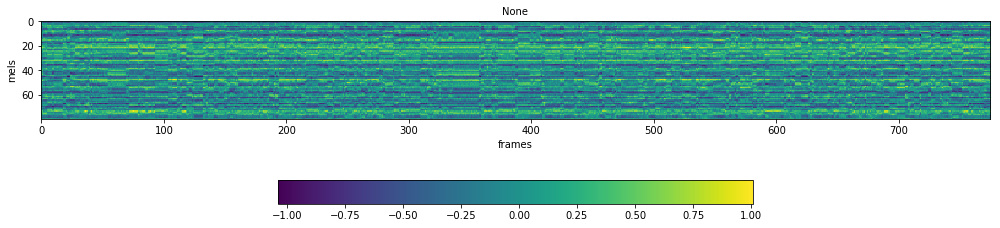

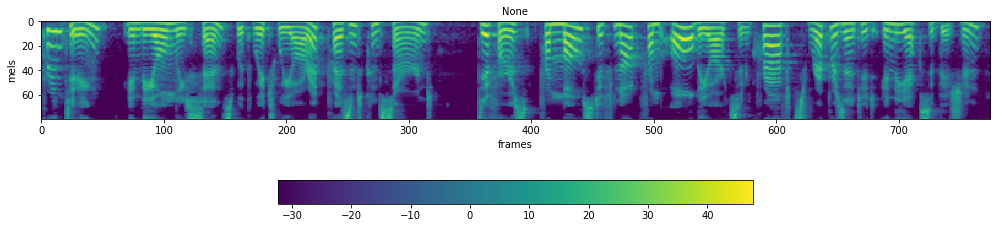

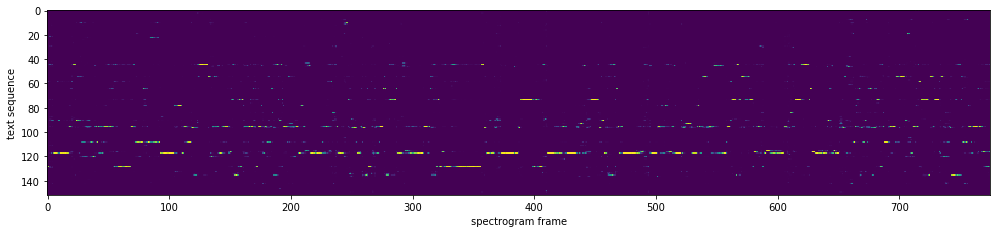

/home/rajanie/.local/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [28]:
## print(outputs)
print(text.data[0])
print("Output plot")

output_plot = show_spectrogram(outputs.data.permute(1, 2, 0)[0],return_array=True)
print("Target plot")
target_plot = show_spectrogram(targets.data.permute(1, 2, 0)[0], return_array=True)
print("attention")
attention_plot = show_attention(masks[0], return_array=True)